In [37]:
import numpy as np
import yaml
from transitleastsquares import transitleastsquares as TLS
from wotan import flatten
import tinygp
from nuance import Nuance

seed = 1
time, flux, error = np.load(f"../data/lightcurves/{seed}.npy")
flux += 1
params = yaml.full_load(open(f"../data/params/{seed}.yaml", "r"))

In [38]:
from time import time as ctime

t0 = ctime()

flatten_flux, flatten_trend = flatten(time, flux, window_length=3*params['duration'], return_trend=True)

model = TLS(time, flatten_flux, verbose=False)
results = model.power(verbose=False, use_threads=1, show_progress_bar=False)

t = ctime() - t0

result_wo = {
    "t0": float(results["T0"]),
    "period": float(results["period"]),
    "time": float(t),
}

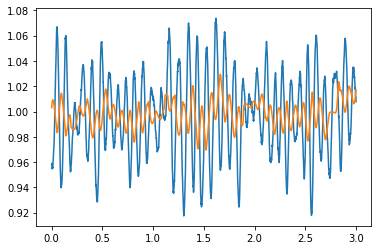

In [39]:
plt.plot(time, flux)
plt.plot(time, flatten_trend)

In [40]:
result_wo

{'t0': 0.09112956252281924,
 'period': 0.689854846607749,
 'time': 0.669741153717041}

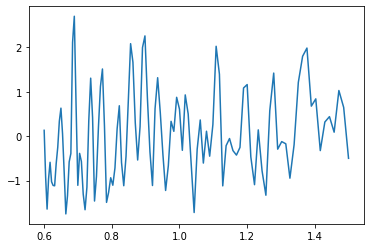

In [41]:
import matplotlib.pyplot as plt

plt.plot(results["periods"], results['power'])

In [42]:
# the right one
kernel = tinygp.kernels.quasisep.SHO(params['omega'], params['quality'], sigma=params["sigma"])
gp = tinygp.GaussianProcess(kernel, time, diag=params['error']**2)

ct0 = ctime()

nu = Nuance(time, flux, gp)

t0s = time.copy()
Ds = np.linspace(0.01, 0.1, 8)
ll, z, vz = nu.linear_search(t0s, Ds, progress=True)

periods = np.linspace(1, 1.6, 2000)
llc, llv = nu.periodic_search(periods, progress=True)

i, j = np.unravel_index(np.argmax(llv), llv.shape)
p0 = periods[i]
t0, D = nu.best_periodic_transit(p0)

t = ctime() - ct0

result_nu = {
    "t0": float(t0),
    "period": float(p0),
    "time": float(t)
}

  0%|          | 0/2160 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

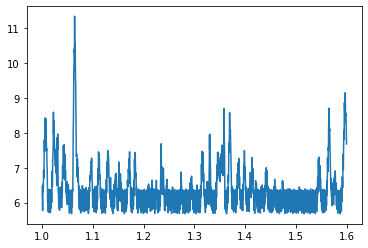

In [43]:
plt.plot(periods, llv.T[j])